# 2 Gaussian mixture models with marginalization and ADVI

##### Keywords: marginalizing over discretes, mixture model, gaussian mixture model, log-sum-exp trick, pymc3

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
import theano.tensor as tt

//anaconda/envs/py3l/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Here is a close set of 2 gaussians.

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
//anaconda/envs/py3l/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


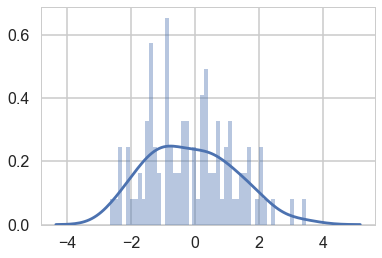

In [3]:
mu_true = np.array([-1, 1])
sigma_true = np.array([1, 1])
lambda_true = np.array([1/2, 1/2])
n = 100
from scipy.stats import multinomial
# Simulate from each distribution according to mixing proportion psi
z = multinomial.rvs(1, lambda_true, size=n)
data=np.array([np.random.normal(mu_true[i.astype('bool')][0], sigma_true[i.astype('bool')][0]) for i in z])
sns.distplot(data, bins=50);

We sample, without imposing any ordering.

In [12]:
with pm.Model() as model1:
    p = [1/2, 1/2]
    means = pm.Normal('means', mu=0, sd=10, shape=2)
    points = pm.NormalMixture('obs', p, mu=means, sd=1, observed=data)



In [13]:
with model1:
    trace1 = pm.sample(10000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [means]
Sampling 2 chains: 100%|██████████| 24000/24000 [00:16<00:00, 1475.85draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127df3400>,
      dtype=object)

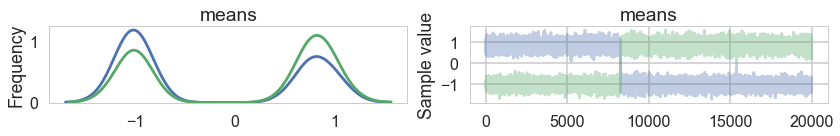

In [14]:
pm.traceplot(trace1, combined=True)

...and land up in a situation where we get mode-switching in one chain

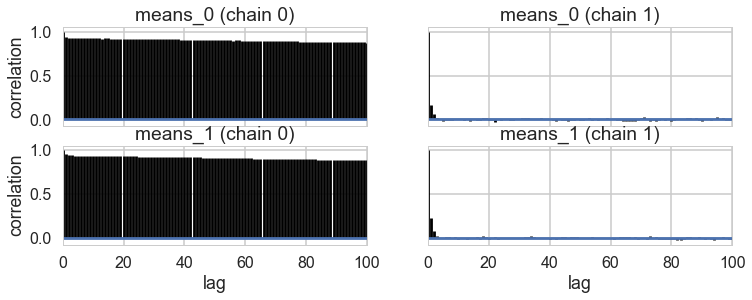

In [16]:
pm.autocorrplot(trace1);

In [42]:
mtrace1 = trace1['means'][::2]
mtrace1.shape

(10000, 2)

In [56]:
np.logspace(-10,2,13)

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

As a result, the 2D posterior becomes multimodal..our sampler is having identifiability problems which show up in the ridiculously bad autocorrelation.

//anaconda/envs/py3l/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


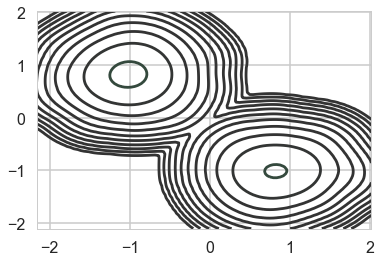

In [59]:
sns.kdeplot(mtrace1[:,0], mtrace1[:,1], n_levels=np.logspace(-10,1,12));

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


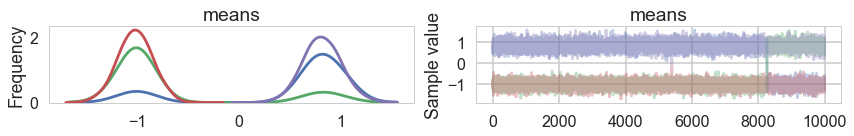

In [26]:
pm.traceplot(trace1);

We fix this by adding an ordering transform

In [18]:
import pymc3.distributions.transforms as tr
with pm.Model() as model2:
    p = [1/2, 1/2]

    means = pm.Normal('means', mu=0, sd=10, shape=2, transform=tr.ordered,
                  testval=np.array([-1, 1]))
    points = pm.NormalMixture('obs', p, mu=means, sd=1, observed=data)

In [29]:
with model2:
    trace2 = pm.sample(10000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [means]
Sampling 2 chains: 100%|██████████| 24000/24000 [00:25<00:00, 951.33draws/s] 


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135cd8438>,
      dtype=object)

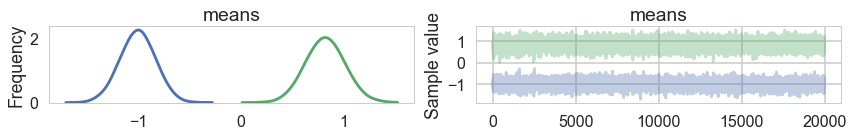

In [30]:
pm.traceplot(trace2, combined=True)

...and the multi-modality goes away...

In [39]:
mtrace2 = trace2['means'][::2]
mtrace2.shape

(10000, 2)

//anaconda/envs/py3l/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


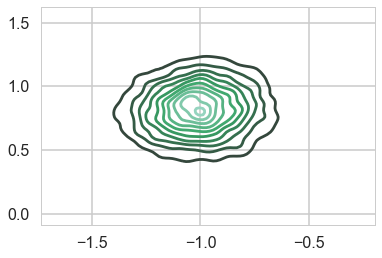

In [61]:
sns.kdeplot(mtrace2[:,0], mtrace2[:,1]);

## ADVI

In [89]:
advi1 = pm.ADVI(model=model1)
advi1.fit(n=15000)

Average Loss = 180.6: 100%|██████████| 15000/15000 [00:11<00:00, 1363.34it/s] 
Finished [100%]: Average Loss = 180.57


(-300, -150)

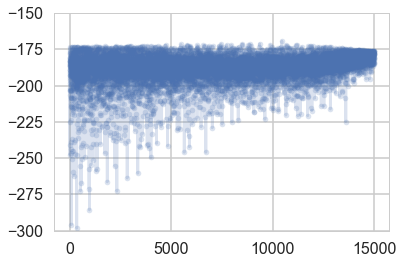

In [90]:
plt.plot(-advi1.hist, '.-', alpha=0.2)
plt.ylim(-300, -150)

In [91]:
samps1=advi1.approx.sample(10000)

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


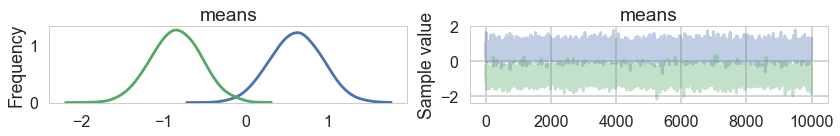

In [92]:
pm.traceplot(samps1);

//anaconda/envs/py3l/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


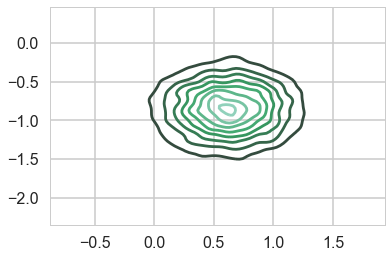

In [93]:
sns.kdeplot(samps1['means'][:,0], samps1['means'][:,1]);

In [68]:
advi2 = pm.ADVI(model=model2)
advi2.fit(n=15000)

Average Loss = 178.08: 100%|██████████| 15000/15000 [00:11<00:00, 1261.75it/s]
Finished [100%]: Average Loss = 178.08


(-300, -150)

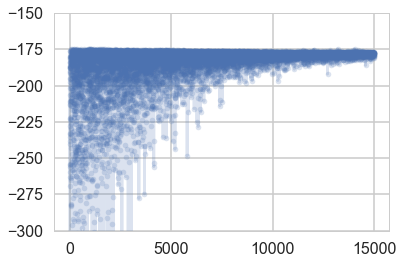

In [72]:
plt.plot(-advi2.hist, '.-', alpha=0.2)
plt.ylim(-300, -150)

In [80]:
samps2=advi2.approx.sample(10000)

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


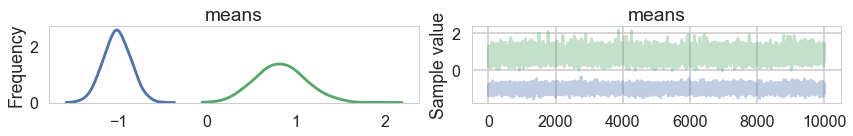

In [81]:
pm.traceplot(samps2);

//anaconda/envs/py3l/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


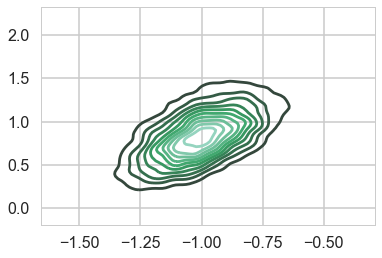

In [82]:
sns.kdeplot(samps2['means'][:,0], samps2['means'][:,1]);